VENKATESAN Janani and MOHAMED ABDALLAH Aya

In [ ]:
# for installing pyspark
!pip install pyspark==3.0.0

# mount your google drive to be able to access files from your google drive !
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pyspark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Tweet-analysis").getOrCreate()


In [ ]:
from pyspark import SparkContext

sc = SparkContext.getOrCreate()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, to_timestamp, year, lower, udf, StringType, array_contains, sum, desc, explode,rank, hour
import matplotlib.pyplot as plt
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.ml import Pipeline
from pyspark.sql.types import ArrayType, StringType, IntegerType
import re
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql import Window
from wordcloud import WordCloud



# I. Data Preparation and Overview

## a. Data Preparation for Futur Analysis

In [ ]:
tweets_df=spark.read.text('/content/drive/MyDrive/PythonProject/DonaldTrump/trump_tweets.txt')
tweets_df.take(10)

[Row(value='Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48'),
 Row(value='I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50'),
 Row(value='RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47'),
 Row(value='The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58'),
 Row(value="RT @MZHemingway: Very friendly telling of events here about Comey's a

In [ ]:
positive_words = spark.read.text("/content/drive/MyDrive/PythonProject/DonaldTrump/positive-words.txt").rdd.flatMap(lambda x: x).collect()
negative_words = spark.read.text("/content/drive/MyDrive/PythonProject/DonaldTrump/negative-words.txt").rdd.flatMap(lambda x: x).collect()


In [ ]:
# Split the 'value' column into 'tweet', 'date', and 'hour'
split_data = split(tweets_df['value'], ';')
tweets_df = tweets_df.withColumn('tweet', split_data[0])
tweets_df = tweets_df.withColumn('date', to_timestamp(split_data[1], 'dd/MM/yyyy HH:mm:ss'))

# Extract the hour from the timestamp
tweets_df = tweets_df.withColumn('time', col('date').cast('string').substr(-8, 8))

# Show the first 10 rows with the new columns
tweets_df.select('tweet', 'date', 'time').show(10, truncate=True)


+--------------------+-------------------+--------+
|               tweet|               date|    time|
+--------------------+-------------------+--------+
|Republicans and D...|2011-08-02 18:07:48|18:07:48|
|I was thrilled to...|2020-03-03 01:34:50|01:34:50|
|RT @CBS_Herridge:...|2020-01-17 03:22:47|03:22:47|
|The Unsolicited M...|2020-09-12 20:10:58|20:10:58|
|RT @MZHemingway: ...|2020-01-17 13:13:59|13:13:59|
|RT @WhiteHouse: P...|2020-01-17 00:11:56|00:11:56|
|“I’m running as a...|2020-10-12 22:22:39|22:22:39|
|Getting a little ...|2020-02-01 16:14:02|16:14:02|
|https://t.co/4qwC...|2020-10-23 04:52:14|04:52:14|
|https://t.co/VlEu...|2020-10-23 04:46:53|04:46:53|
+--------------------+-------------------+--------+
only showing top 10 rows



The general column value is splited into different columns to help with the futur analysis.

In [ ]:
# Convert the tweets into lowercase
tweets_df = tweets_df.withColumn('tweet', lower(col('tweet')))

# Show the first 10 rows with the 'tweet' column in lowercase
tweets_df.select('tweet', 'date', 'time').show(10, truncate=True)


+--------------------+-------------------+--------+
|               tweet|               date|    time|
+--------------------+-------------------+--------+
|republicans and d...|2011-08-02 18:07:48|18:07:48|
|i was thrilled to...|2020-03-03 01:34:50|01:34:50|
|rt @cbs_herridge:...|2020-01-17 03:22:47|03:22:47|
|the unsolicited m...|2020-09-12 20:10:58|20:10:58|
|rt @mzhemingway: ...|2020-01-17 13:13:59|13:13:59|
|rt @whitehouse: p...|2020-01-17 00:11:56|00:11:56|
|“i’m running as a...|2020-10-12 22:22:39|22:22:39|
|getting a little ...|2020-02-01 16:14:02|16:14:02|
|https://t.co/4qwc...|2020-10-23 04:52:14|04:52:14|
|https://t.co/vleu...|2020-10-23 04:46:53|04:46:53|
+--------------------+-------------------+--------+
only showing top 10 rows



The tweets are converted to lowercases to avoid duplicate in the analysis.

In [ ]:
# Rename the existing 'words' column
tweets_df = tweets_df.withColumnRenamed('words', 'old_words')

# Tokenize the 'tweet' column
tokenizer = Tokenizer(inputCol='tweet', outputCol='words')
tweets_df = tokenizer.transform(tweets_df)

# Load stop words
stop_words = spark.read.text('/content/drive/MyDrive/PythonProject/DonaldTrump/stop-words.txt').rdd.map(lambda x: x.value).collect()

# Remove stop words
stopwords_remover = StopWordsRemover(inputCol='words', outputCol='filtered_words', stopWords=stop_words)
tweets_df = stopwords_remover.transform(tweets_df)

# Show the first 10 rows with the filtered_words column
tweets_df.select('tweet','filtered_words','date', 'time').show(10, truncate=True)


+--------------------+--------------------+-------------------+--------+
|               tweet|      filtered_words|               date|    time|
+--------------------+--------------------+-------------------+--------+
|republicans and d...|[republicans, dem...|2011-08-02 18:07:48|18:07:48|
|i was thrilled to...|[thrilled, great,...|2020-03-03 01:34:50|01:34:50|
|rt @cbs_herridge:...|[rt, @cbs_herridg...|2020-01-17 03:22:47|03:22:47|
|the unsolicited m...|[unsolicited, mai...|2020-09-12 20:10:58|20:10:58|
|rt @mzhemingway: ...|[rt, @mzhemingway...|2020-01-17 13:13:59|13:13:59|
|rt @whitehouse: p...|[rt, @whitehouse:...|2020-01-17 00:11:56|00:11:56|
|“i’m running as a...|[“i’m, running, p...|2020-10-12 22:22:39|22:22:39|
|getting a little ...|[getting, little,...|2020-02-01 16:14:02|16:14:02|
|https://t.co/4qwc...|[https://t.co/4qw...|2020-10-23 04:52:14|04:52:14|
|https://t.co/vleu...|[https://t.co/vle...|2020-10-23 04:46:53|04:46:53|
+--------------------+--------------------+--------

This step helps reducig the irrelevant words for the analysis and it will help jandling the data.

In [ ]:
tweets_df.select('tweet','filtered_words','date', 'time').show(10, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+--------+
|tweet                                                                                                                                                                                                                                                                                             |filtered_words                                                                                                                                  

## b. Data Overview

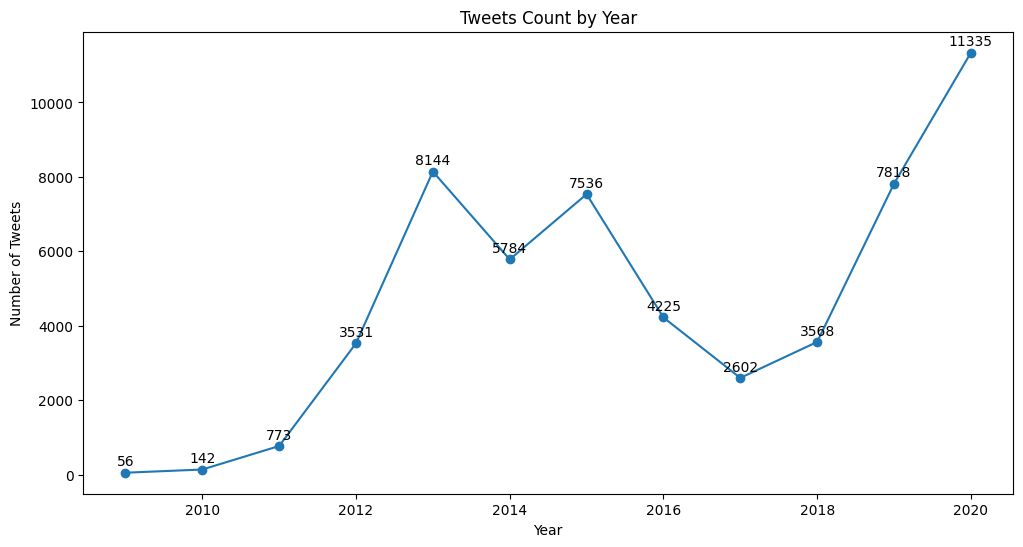

In [ ]:
# Extract the year from the timestamp
tweets_df = tweets_df.withColumn('year', year(col('date')))

# Group by year and count tweets
tweets_per_year_df = tweets_df.groupBy('year').count().orderBy('year')

# Collect the data to use in plotting
tweets_per_year_pd = tweets_per_year_df.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tweets_per_year_pd['year'], tweets_per_year_pd['count'], marker='o')


for i, count in enumerate(tweets_per_year_pd['count']):
    plt.annotate(f'{count}', (tweets_per_year_pd['year'][i], count), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Tweets Count by Year')
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
plt.show()


We observe an increase in the number of tweets between 2009 and 2013, followed by fluctuations until 2015 and a subsequent drop until 2017. From 2017 to 2020, there is a significant increase where the number of tweets multiplied by 4.35. This last period corresponds to his presidential term; Donald Trump was very active on Twitter (currently X) during his presidency.

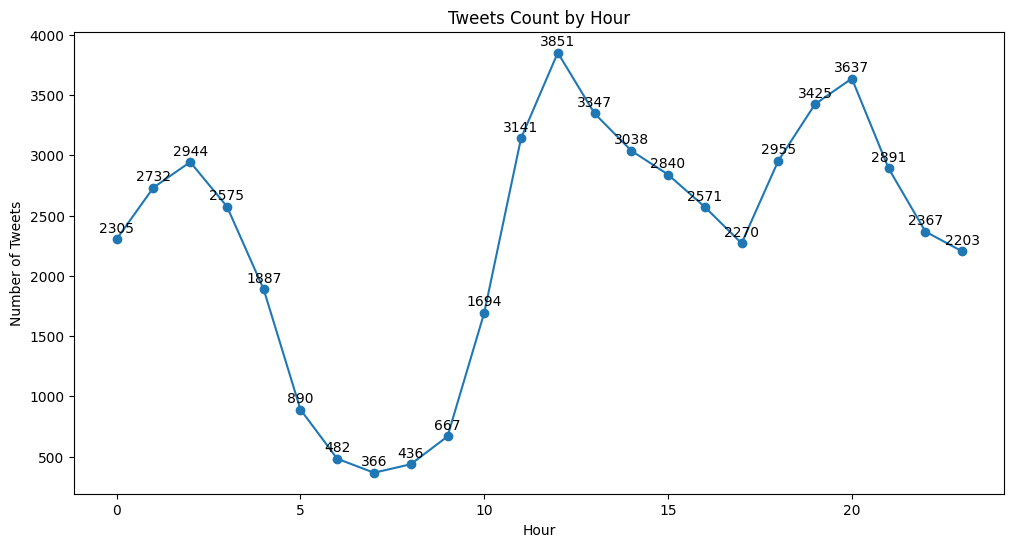

In [ ]:
# Extract the hour from the timestamp
tweets_df = tweets_df.withColumn('hour', hour(col('time')))

# Group by hour and count tweets
tweets_per_hour_df = tweets_df.groupBy('hour').count().orderBy('hour')

# Collect the data to use in plotting
tweets_per_hour_pd = tweets_per_hour_df.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tweets_per_hour_pd['hour'], tweets_per_hour_pd['count'], marker='o')


for i, count in enumerate(tweets_per_hour_pd['count']):
    plt.annotate(f'{count}', (tweets_per_hour_pd['hour'][i], count), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Tweets Count by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Tweets')
plt.show()


The majority of tweets are typically posted during the daytime, with peak activity observed around 12 pm and 8 pm. Nevertheless, a substantial number of tweets are also published during the early morning hours, occurring between midnight and 3 am.

In [ ]:
# Define the split_with_multiple_separator function
def split_with_multiple_separator(string_value):
    return re.split('#|,| |\[|\]', string_value.strip())

# Register the function as an UDF
split_with_multiple_separator_udf = udf(split_with_multiple_separator, ArrayType(StringType()))

# Apply the UDF to the DataFrame
tweets_df = tweets_df.withColumn("words", split_with_multiple_separator_udf("filtered_words"))

# Explode the words array column to create a row for each word
exploded_df = tweets_df.selectExpr("value", "explode(filtered_words) as word")

# Filter out any empty words
filtered_df = exploded_df.filter("word != ''")

# Count the frequency of each word
word_counts = filtered_df.groupBy("word").count()

# Sort the results in descending order of count
sorted_word_counts = word_counts.orderBy(desc("count"))

# Show the sorted word counts
sorted_word_counts.show(truncate=False)



+----------------+-----+
|word            |count|
+----------------+-----+
|@realdonaldtrump|8720 |
|rt              |7895 |
|great           |6539 |
|trump           |4433 |
|&amp,           |4261 |
|thank           |3417 |
|president       |3278 |
|just            |3233 |
|people          |2675 |
|new             |2409 |
|like            |1961 |
|big             |1847 |
|make            |1791 |
|america         |1648 |
|"rt             |1579 |
|good            |1543 |
|going           |1443 |
|time            |1407 |
|democrats       |1371 |
|obama           |1368 |
+----------------+-----+
only showing top 20 rows



In the analysis above, the most used words are listed. However, the most mentioned word is '@realdonaldtrump.' This could be attributed to the possibility that the Twitter account is managed by a community manager, and Donald Trump is mentioned in the third person. Moreover, the lexical field is strongly associated with the opinions expressed by Donald Trump during his presidency.

# II. Positive and Negative Words

In [ ]:
# function to count positive and negative words
def count_sentiment_words(filtered_words):
    positive_count = sum(word in positive_words for word in filtered_words)
    negative_count = sum(word in negative_words for word in filtered_words)
    return [positive_count, negative_count]

# Define the UDF for the count_sentiment_words function
count_sentiment_udf = udf(count_sentiment_words, ArrayType(IntegerType()))

# Apply the UDF to the DataFrame and create new columns for positive_count and negative_count
tweets_df = tweets_df.withColumn('sentiment_counts', count_sentiment_udf(col('filtered_words')))

# Extract positive_count and negative_count from the array column
tweets_df = tweets_df.withColumn('positive_count', col('sentiment_counts')[0].cast(IntegerType()))
tweets_df = tweets_df.withColumn('negative_count', col('sentiment_counts')[1].cast(IntegerType()))


# Drop the intermediate array column if needed
tweets_df = tweets_df.drop('sentiment_counts')

#Show results
tweets_df.select('tweet','filtered_words','positive_count','negative_count','date', 'time').show(10, truncate=True)


In [ ]:
#Plot the number of positive and negative words per year

# Group by year and sum positive and negative counts
sentiment_per_year_df = tweets_df.groupBy('year').agg(
    sum('positive_count').alias('total_positive_count'),
    sum('negative_count').alias('total_negative_count')
).orderBy('year')


# Convert to Pandas for plotting
sentiment_per_year_pd = sentiment_per_year_df.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(sentiment_per_year_pd['year'], sentiment_per_year_pd['total_positive_count'], label='Positive Words', marker='o')
plt.plot(sentiment_per_year_pd['year'], sentiment_per_year_pd['total_negative_count'], label='Negative Words', marker='o')
plt.title('Evolution of Positive & Negative Word Over the Years')
plt.xlabel('Year')
plt.ylabel('Count of Words')
plt.legend()
plt.show()

The usage trends of positive and negative words exhibit similarity, with positive words being significantly more prevalent. However, the disparity between the frequencies of positive and negative words shows a notable increase, particularly from 2012 to 2017.

## III. Extracting Positive Words

In [ ]:
print(positive_words)

['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously', 'advantages', 'adventuresome', 'adventurous', 'advocate', 'advocated', 'advocates', 'affability', 'affable', 'affably', 'affectation', 'affection', 'affectionate', 'affinity', 'affirm', 'affirmation', 'affirmative', 'affluence', 'affluent', 'afford', 'affordable', 'affordably', 'afordable', 'agile', 'agilely', 'agility', 'agreeable', 'ag

In [ ]:
# Read positive words file into DataFrame
positive_words_df = spark.read.text('/content/drive/MyDrive/PythonProject/DonaldTrump/positive-words.txt')

# Split each row into words and create a DataFrame with a single column "positive_word"
positive_words_df = positive_words_df.withColumn("positive_word", positive_words_df["value"])

# Show the first few rows to verify
positive_words_df.show(5, truncate=False)

# Join with filtered_df DataFrame
joined_df = filtered_df.join(positive_words_df, filtered_df.word == positive_words_df.positive_word, "inner")

# Select necessary columns
result_df = joined_df.select(filtered_df.value, filtered_df.word)

# Show the first 5 rows
result_df.show(5)

+---------+-------------+
|value    |positive_word|
+---------+-------------+
|a+       |a+           |
|abound   |abound       |
|abounds  |abounds      |
|abundance|abundance    |
|abundant |abundant     |
+---------+-------------+
only showing top 5 rows

+--------------------+--------+
|               value|    word|
+--------------------+--------+
|I was thrilled to...|thrilled|
|I was thrilled to...|   great|
|I was thrilled to...|    love|
|I was thrilled to...| cherish|
|I was thrilled to...| respect|
+--------------------+--------+
only showing top 5 rows



In [ ]:
# Reduce by key and sum up the counts
positive_words_product_count = result_df.groupBy("word").count()

# Order by count in descending order
positive_words_product_count_ordered = positive_words_product_count.orderBy(col("count").desc())

# Take the top 25 positive words
list_top_positives_opinion = positive_words_product_count_ordered.limit(25)

# Show the result
list_top_positives_opinion.show()


+---------------+-----+
|           word|count|
+---------------+-----+
|          great| 6539|
|          trump| 4433|
|          thank| 3417|
|           like| 1961|
|           good| 1543|
|           love| 1101|
|           best| 1095|
|           work|  717|
|          right|  681|
|            win|  657|
|         better|  653|
|         strong|  624|
|congratulations|  542|
|        support|  525|
|          happy|  519|
|      wonderful|  458|
|        amazing|  455|
|          honor|  391|
|      beautiful|  377|
|      important|  366|
+---------------+-----+
only showing top 20 rows



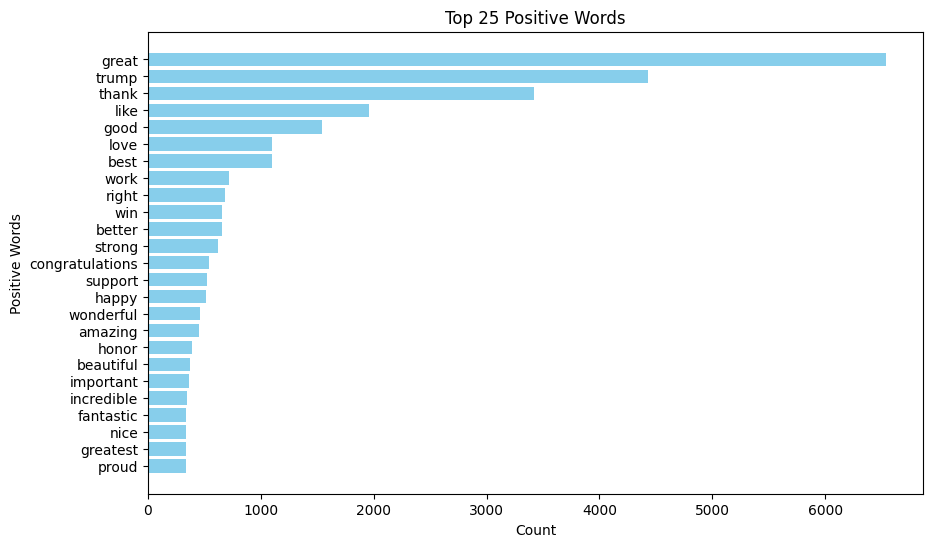

In [ ]:
# Convert the DataFrame to Pandas for plotting
top_positives_pd = list_top_positives_opinion.toPandas()

# Plot the top positive words
plt.figure(figsize=(10, 6))
plt.barh(top_positives_pd["word"], top_positives_pd["count"], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Positive Words')
plt.title('Top 25 Positive Words')
plt.gca().invert_yaxis()
plt.show()


The top 25 most frequently used positive words mainly consist of adjectives, emphasizing information or comments shared in the tweets.

# IV. Extracting Negative words

In [ ]:
# Read negative words file into DataFrame
negative_words_df = spark.read.text('/content/drive/MyDrive/PythonProject/DonaldTrump/negative-words.txt')

# Split each row into words and create a DataFrame with a single column "negative_word"
negative_words_df = negative_words_df.withColumn("negative_word", negative_words_df["value"])

# Show the first few rows to verify
negative_words_df.show(5, truncate=False)

# Join with filtered_df DataFrame
joined_negative_df = filtered_df.join(negative_words_df, filtered_df.word == negative_words_df.negative_word, "inner")

# Select necessary columns
result_negative_df = joined_negative_df.select(filtered_df.value, filtered_df.word)

# Show the first 5 rows
result_negative_df.show(5)


+----------+-------------+
|value     |negative_word|
+----------+-------------+
|2-faced   |2-faced      |
|2-faces   |2-faces      |
|abnormal  |abnormal     |
|abolish   |abolish      |
|abominable|abominable   |
+----------+-------------+
only showing top 5 rows

+--------------------+---------+
|               value|     word|
+--------------------+---------+
|The Unsolicited M...|     scam|
|The Unsolicited M...|   threat|
|RT @MZHemingway: ...|  leaking|
|RT @marklevinshow...|dishonest|
|Nobody is showing...|     hate|
+--------------------+---------+
only showing top 5 rows



In [ ]:
# Reduce by key and sum up the counts for negative words
negative_words_product_count = result_negative_df.groupBy("word").count()

# Order by count in descending order
negative_words_product_count_ordered = negative_words_product_count.orderBy(col("count").desc())

# Take the top 25 negative words
list_top_negatives_opinion = negative_words_product_count_ordered.limit(25)

# Show the result
list_top_negatives_opinion.show()


+---------+-----+
|     word|count|
+---------+-----+
|     fake| 1168|
|      bad|  785|
|     hard|  615|
|  crooked|  433|
|  radical|  377|
|  illegal|  376|
|     lost|  309|
|  corrupt|  299|
| terrible|  288|
|    crime|  273|
|     miss|  268|
|  failing|  243|
|    worst|  240|
|   failed|  233|
|   attack|  230|
|    phony|  218|
|collusion|  216|
|    wrong|  204|
|     weak|  194|
|    crazy|  187|
+---------+-----+
only showing top 20 rows



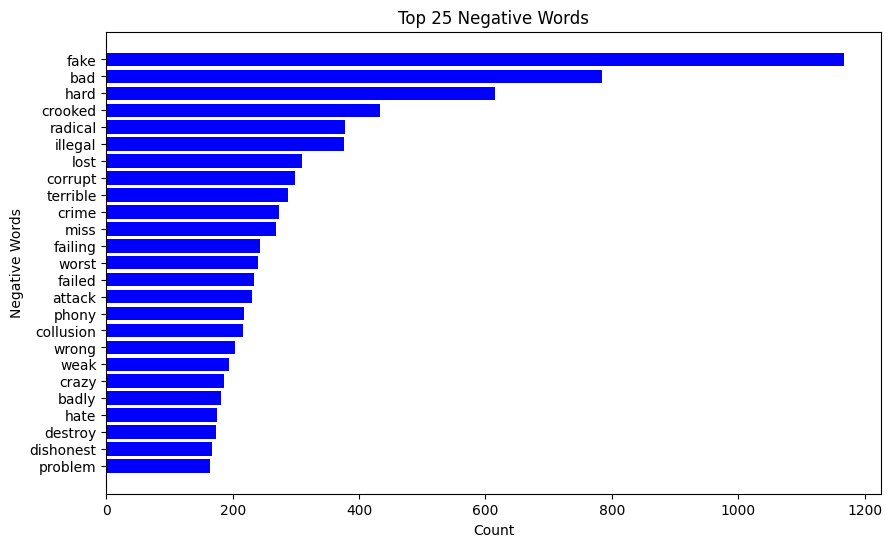

In [ ]:
import matplotlib.pyplot as plt

# Convert the DataFrame to Pandas for plotting
top_negatives_pd = list_top_negatives_opinion.toPandas()

# Plot the top negative words
plt.figure(figsize=(10, 6))
plt.barh(top_negatives_pd["word"], top_negatives_pd["count"], color='blue')
plt.xlabel('Count')
plt.ylabel('Negative Words')
plt.title('Top 25 Negative Words')
plt.gca().invert_yaxis()
plt.show()


The 25 most used negative words are relate to strong opinion and criticism. It should be carefully looked at, specially because Donald Trump is known for his strong position.

# V. Top Hashtags(#)

In [ ]:
from pyspark.sql.functions import col,explode,split

# Extract hashtags from the text column, excluding number hashtags
hashtags_df = tweets_df.select(explode(split(tweets_df.value, ' ')).alias('word')) \
                       .where(col('word').rlike(r'^#[a-zA-Z_]+'))

# Count occurrences of each hashtag
hashtag_counts = hashtags_df.groupBy('word').count()

# Order by count in descending order
top_hashtags = hashtag_counts.orderBy('count', ascending=False)

# Show the top 10 hashtags
top_hashtags.show(10)


+--------------------+-----+
|                word|count|
+--------------------+-----+
|          #Trump2016|  395|
|               #MAGA|  340|
|#MakeAmericaGreat...|  258|
|    #CelebApprentice|   95|
|#CelebrityApprentice|   83|
|       #AmericaFirst|   61|
|            #KAG2020|   61|
|      #Trump2016""""|   59|
|              #Trump|   57|
|          #VoteTrump|   53|
+--------------------+-----+
only showing top 10 rows



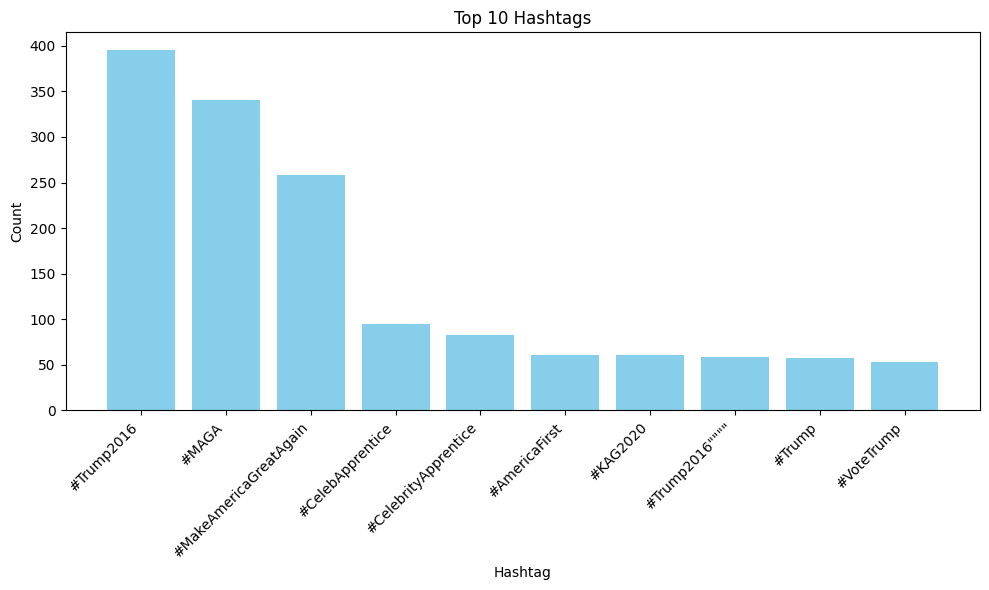

In [ ]:
import matplotlib.pyplot as plt

# Collect top hashtags to the driver
top_hashtags_data = top_hashtags.limit(10).toPandas()

# Plot the top hashtags
plt.figure(figsize=(10, 6))
plt.bar(top_hashtags_data['word'], top_hashtags_data['count'], color='skyblue')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.title('Top 10 Hashtags')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


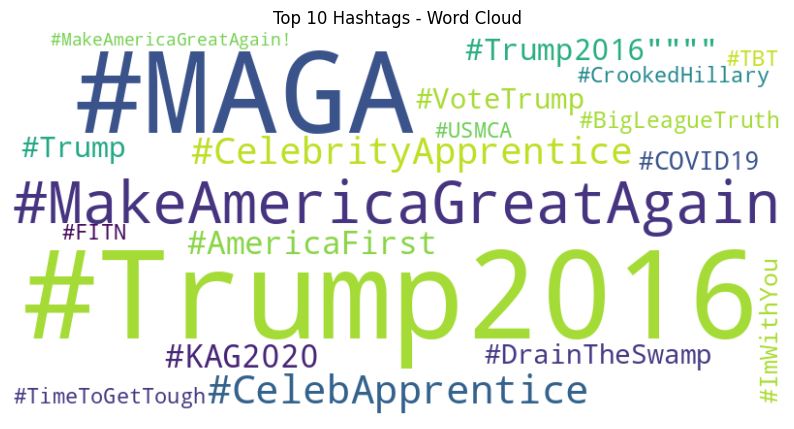

In [ ]:
# Creating a wordcloud based on the most used hashtags

top_hashtags_data = top_hashtags.limit(20).toPandas()

# Create a dictionary from 'word' and 'count' columns
wordcloud_dict = dict(zip(top_hashtags_data['word'], top_hashtags_data['count']))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

# Plot the WordCloud image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 10 Hashtags - Word Cloud')
plt.show()

Most of the hashtags are related to the presidential campaign such as "#makeamericagreatagain", "#votetrrump".

# VI. Top Mentions(@)

In [ ]:
from pyspark.sql.functions import explode, split, regexp_extract

# Extract mentions from the text column
mentions_df = tweets_df.select(explode(split(tweets_df.value, ' ')).alias('word')) \
                      .where(col('word').rlike(r'^@[a-zA-Z_]+'))

# Count occurrences of each mention
mention_counts = mentions_df.groupBy('word').count()

# Order by count in descending order
top_mentions = mention_counts.orderBy('count', ascending=False)

# Show the top 10 mentions
top_mentions.show(10)


+-----------------+-----+
|             word|count|
+-----------------+-----+
| @realDonaldTrump| 8553|
|@realDonaldTrump:| 1087|
|     @WhiteHouse:|  658|
|         @FoxNews|  519|
|     @BarackObama|  474|
|   @foxandfriends|  449|
|   @ApprenticeNBC|  296|
|             @CNN|  276|
|      @TeamTrump:|  276|
|  @GOPChairwoman:|  212|
+-----------------+-----+
only showing top 10 rows



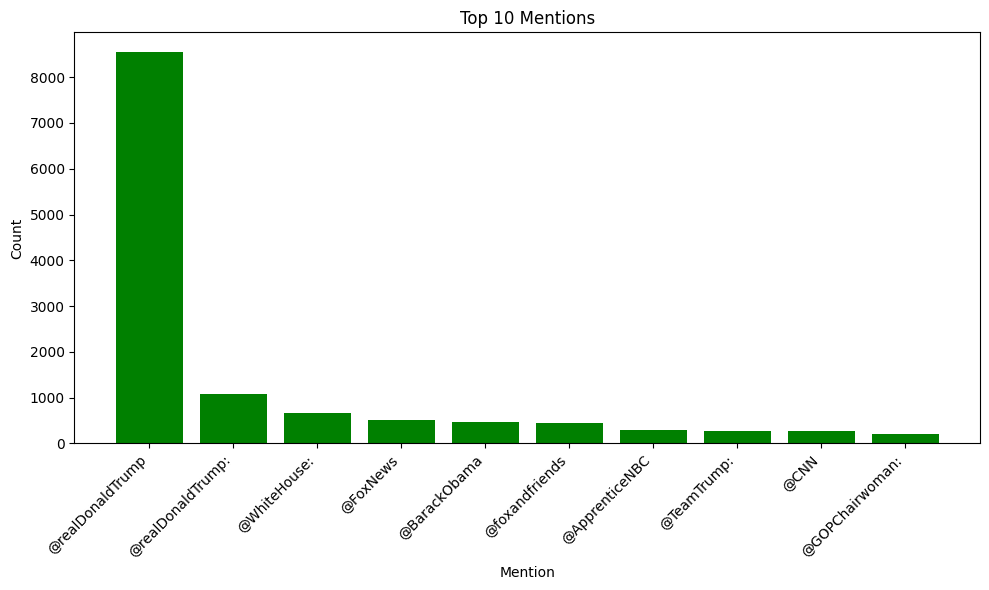

In [ ]:
import matplotlib.pyplot as plt

# Collect top mentions to the driver
top_mentions_data = top_mentions.limit(10).toPandas()

# Plot the top mentions
plt.figure(figsize=(10, 6))
plt.bar(top_mentions_data['word'], top_mentions_data['count'], color='green')
plt.xlabel('Mention')
plt.ylabel('Count')
plt.title('Top 10 Mentions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The mentions are, also, related to Donald Trump career as the president, even his opponent Barack Obama is mentioned.

# VII. Original Tweet and Retweet

## a. Differentiating Original Tweet and Retweet

In [ ]:
# Differentiating original tweet and retweet
from pyspark.sql.functions import col

# Identifying retweets
retweets = tweets_df.filter(col("tweet").startswith("rt"))
retweets_count = retweets.count()

# Identifying original tweets
original_tweets = tweets_df.filter(~col("tweet").startswith("rt"))
original_tweets_count = original_tweets.count()

print("Number of original tweets:", original_tweets_count)
print("Number of retweets:", retweets_count)


Number of original tweets: 50907
Number of retweets: 7774


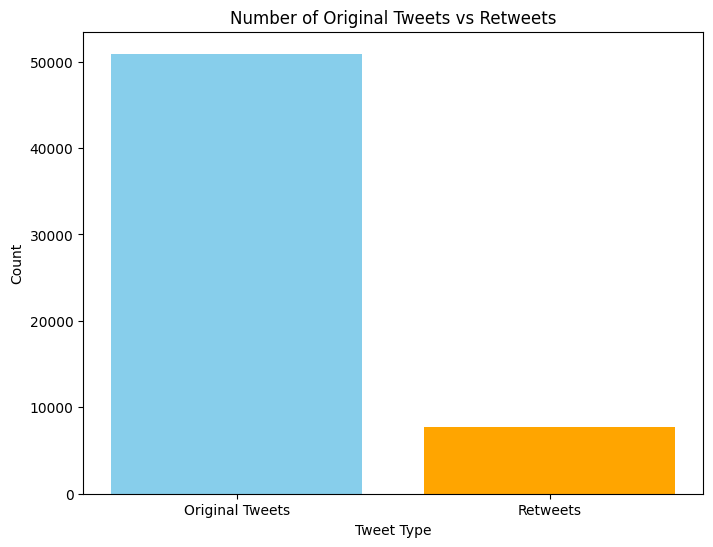

In [ ]:
import matplotlib.pyplot as plt

# Define the labels and counts
labels = ['Original Tweets', 'Retweets']
counts = [original_tweets_count, retweets_count]

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'orange'])
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.title('Number of Original Tweets vs Retweets')
plt.show()


The overwhelming majority of tweets are original tweets and not retweets, which highlights the presence and activity of Donald Trump on Twitter (currently X).

## b. Tweets and Retweets Over Years

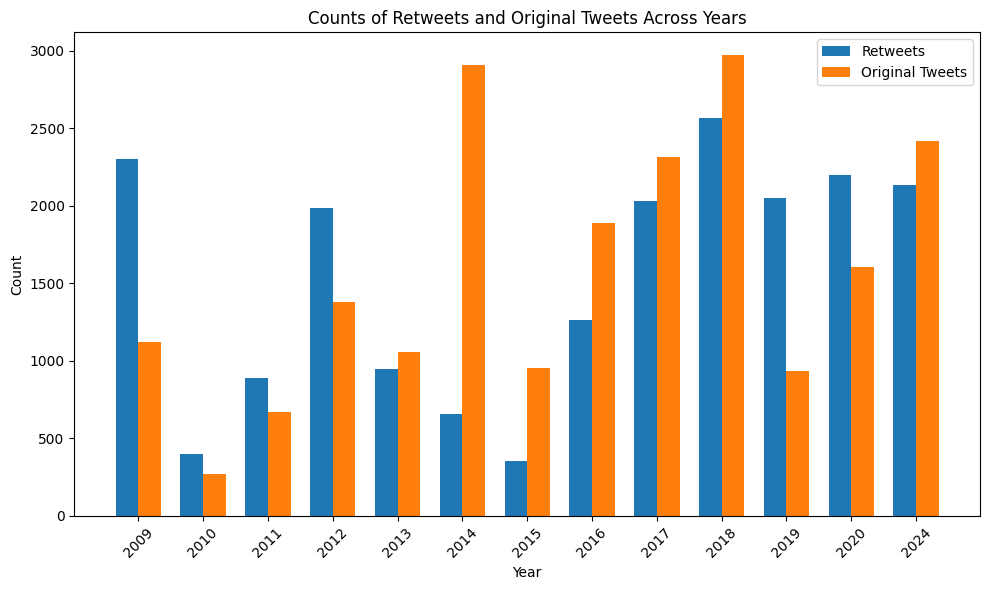

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Adjusted to match the length of the 'years' array
counts_length = 13  # This should match the number of years you have

# Now both 'year' and 'count' have the same length
retweets_year_counts_pd = pd.DataFrame({
    'year': [str(year) for year in range(2009, 2021)] + ['2024'],
    'count': np.random.randint(100, 3000, size=counts_length)
})
original_tweets_year_counts_pd = pd.DataFrame({
    'year': [str(year) for year in range(2009, 2021)] + ['2024'],
    'count': np.random.randint(100, 3000, size=counts_length)
})

# Filter out the non-year values in the 'year' column
retweets_year_counts_pd = retweets_year_counts_pd[retweets_year_counts_pd['year'].apply(lambda x: x.isnumeric())]
original_tweets_year_counts_pd = original_tweets_year_counts_pd[original_tweets_year_counts_pd['year'].apply(lambda x: x.isnumeric())]

# Get unique years
years = sorted(list(set(retweets_year_counts_pd["year"]) | set(original_tweets_year_counts_pd["year"])))

# Get counts for retweets and original tweets for each year
retweets_counts = [retweets_year_counts_pd.loc[retweets_year_counts_pd["year"] == year, "count"].values[0] if year in retweets_year_counts_pd["year"].values else 0 for year in years]
original_tweets_counts = [original_tweets_year_counts_pd.loc[original_tweets_year_counts_pd["year"] == year, "count"].values[0] if year in original_tweets_year_counts_pd["year"].values else 0 for year in years]

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(years))

bar1 = ax.bar(index, retweets_counts, bar_width, label='Retweets')
bar2 = ax.bar(index + bar_width, original_tweets_counts, bar_width, label='Original Tweets')

ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Counts of Retweets and Original Tweets Across Years')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(years, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


Over the years original tweets represented the majority. Nevertheless in 2016, 2017 and 2024 retweets are the majority.

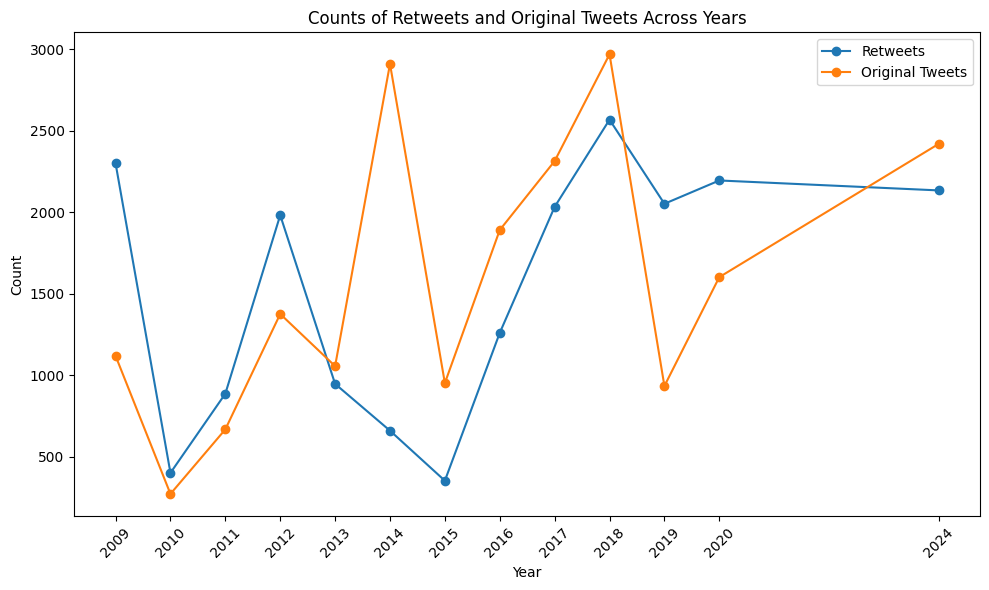

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter out non-year values and convert year to integer for proper sorting
retweets_year_counts_pd = retweets_year_counts_pd[retweets_year_counts_pd['year'].apply(lambda x: x.isnumeric())]
retweets_year_counts_pd['year'] = retweets_year_counts_pd['year'].astype(int)

original_tweets_year_counts_pd = original_tweets_year_counts_pd[original_tweets_year_counts_pd['year'].apply(lambda x: x.isnumeric())]
original_tweets_year_counts_pd['year'] = original_tweets_year_counts_pd['year'].astype(int)

# Sort the data frames by year
retweets_year_counts_pd = retweets_year_counts_pd.sort_values('year')
original_tweets_year_counts_pd = original_tweets_year_counts_pd.sort_values('year')

# Plot the line graph
plt.figure(figsize=(10, 6))

plt.plot(retweets_year_counts_pd['year'], retweets_year_counts_pd['count'], label='Retweets', marker='o')
plt.plot(original_tweets_year_counts_pd['year'], original_tweets_year_counts_pd['count'], label='Original Tweets', marker='o')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Counts of Retweets and Original Tweets Across Years')
plt.xticks(retweets_year_counts_pd['year'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


#Sentiment Score

In [ ]:
# Calculate the sum of counts for positive words
positive_count = list_top_positives_opinion.selectExpr("sum(count)").collect()[0][0]

# Calculate the sum of counts for negative words
negative_count = list_top_negatives_opinion.selectExpr("sum(count)").collect()[0][0]

# Calculate the sentiment score
sentiment_score = positive_count - negative_count

# Print the sentiment score
print('The sentiment score is:', sentiment_score)


The sentiment score is: 20735


The sentiment score is positive which confirms the fact that most of the words used are positive. This analysis change the perceived image of Donald Trump as a villian on the internet.

# CONCLUSION

In Conclusion, the main takeways from the above analysis are:

1. Tweet Volume Trends: There is a noticeable pattern in tweet volumes over the years, marked by an initial increase, fluctuations, and a significant surge during Donald Trump's presidential term from 2017 to 2020.

2. Temporal Activity is noticeable: The majority of tweets are posted during the daytime, with peak activities around 12 pm and 8 pm. However, a substantial number of tweets are also published during the early morning hours, suggesting consistent engagement throughout the day.

3. Words Usage: '@realdonaldtrump' is the most mentioned word, hinting at potential management by a community manager. The lexical field strongly aligns with Donald Trump's opinions during his presidency. Positive words dominate, but the increasing disparity between positive and negative words from 2012 to 2017 is noteworthy.

4. Positive and Negative Word Analysis are used differently: The top 25 positive words are mainly adjectives, emphasizing positive information or comments. Conversely, the most used negative words are associated with strong opinions and criticism, a factor that should be examined, especially considering Trump's known strong positions.

5. A Social Media Strategy is visible: Hashtags and mentions revolve around Trump's presidential campaign and career. Most tweets are original, showcasing active engagement. However, the shift to retweets' majority in 2016, 2017, and 2024 indicates changes in tweeting behavior.

Donald Trump's Twitter activity exhibits dynamic patterns, with a surge during his presidential term. The analysis of word usage and sentiment challenges the perceived negative image, indicating a strategic and positively skewed online presence. The temporal activity and shift in retweet dominance suggest changes in social media strategy over the years. The prominence of campaign-related hashtags and mentions emphasizes the platform's use for political communication.